# Pix2Pix MAR Walkthrough Notebook


## Set Up

This section imports libraries, sets parameters, and loads the model

### Importing Libraries

In [38]:
# Imports
import os
import random
import torch
import matplotlib.pyplot as plt
import json
import numpy as np

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

from pix2pixGAN.generator import UnetGenerator  # Assuming the generator architecture is in generator.py

### Inputs

In [2]:
Dataset_path = 'Data/Dataset/Test' # path to testing set

weights = 'Experiments/Experiment_002_augmentation_False_epochs_200/generator_002.pt'
exp_path = 'Experiments/Experiment_002_augmentation_False_epochs_200/November_14_2024_04_32AM_Metal_Artifacts_New.json'

outputs_dir = 'outputs' # path to save outputs of this notebook
model_name = 'epoch-200' # to be added to the filename of the saved images from inference

### Model

In [3]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the trained generator model
generator = UnetGenerator().to(device)
generator.load_state_dict(torch.load(weights, map_location=device, weights_only=True))
generator.eval()  # Set model to evaluation mode

# Transformation to match training preprocessing (e.g., normalization)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Inverse transform for visualization (to undo normalization)
inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-1], std=[2]),  # Reverse normalization if mean=0.5, std=0.5
    transforms.ToPILImage()
])

c:\Users\PC\anaconda3\envs\VL-MOT\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## Inference

This section walks through the inference process. 


### Load Images

In [22]:
metal_dir = os.path.join(Dataset_path, 'Metal')
gt_dir = os.path.join(Dataset_path, 'GT')

# List and sort filenames in both directories
metal_files = sorted(os.listdir(metal_dir))  # Sorted list of files in Metal
gt_files = sorted(os.listdir(gt_dir))        # Sorted list of files in GT

# Find common filenames
common_files = [file for file in metal_files if file in gt_files]

# Set a random seed for reproducibility
random.seed(619)  # Use any fixed number as seed
selected_files = random.sample(common_files, 3)  # Randomly select 3 matching files

# Construct the full paths for the selected images
selected_metal_images = [os.path.join(metal_dir, file) for file in selected_files]
selected_gt_images = [os.path.join(gt_dir, file) for file in selected_files]

metal_images = [Image.open(path) for path in selected_metal_images]
gt_images = [Image.open(path) for path in selected_gt_images]

print('Selcted Images:')
print(selected_metal_images)

Selcted Images:
['Data/Dataset/Test\\Metal\\6-1-6-2 (188).png', 'Data/Dataset/Test\\Metal\\3-1-3-4 (122).png', 'Data/Dataset/Test\\Metal\\5-1-5-2 (221).png']


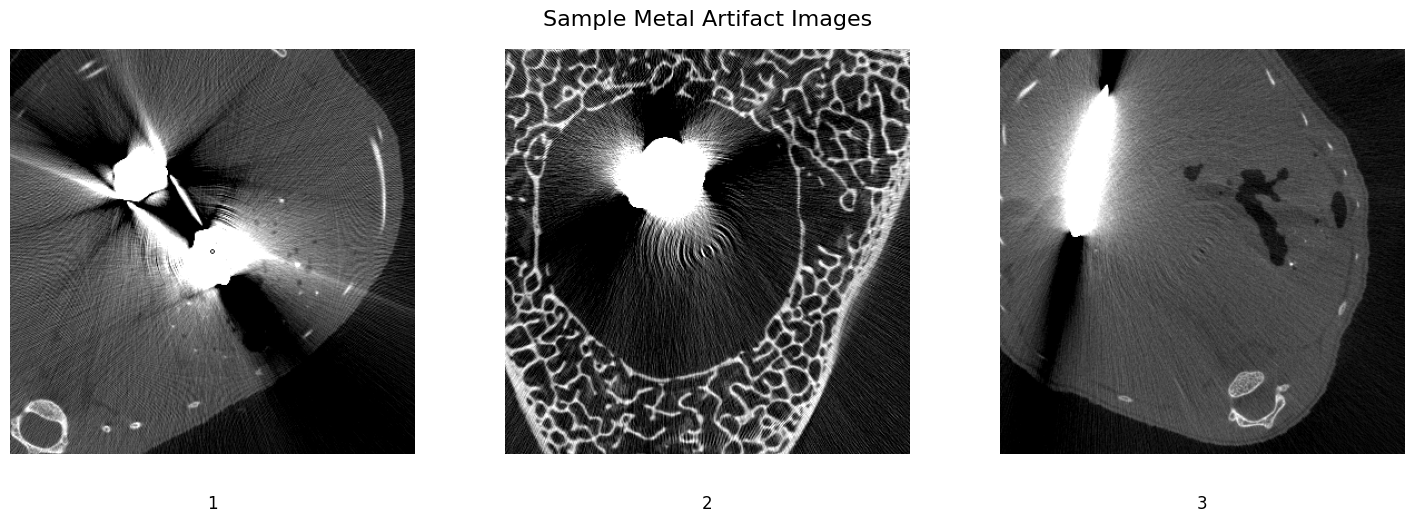

In [23]:
# Visualizing the sample images

def display_images(image_list, title):
    assert len(image_list) == 3, "The image_list must contain exactly 3 images."
    
    # Create the figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)
    
    # Plot each image
    for i, (image, ax) in enumerate(zip(image_list, axes)):
        ax.imshow(image, cmap="grey")
        ax.axis('off')
        ax.text(
            0.5, -0.1,  # Position below the image
            str(i + 1),  # Number to display
            transform=ax.transAxes,  # Use axis coordinates
            fontsize=12,
            ha='center',  # Center the text horizontally
            va='top'  # Align text to the top of its position
        )
    
    plt.tight_layout()
    plt.show()

display_images(metal_images, "Sample Metal Artifact Images")

### Forward Pass

In [24]:
inference_images = []
for i, ma_image in enumerate(metal_images):
    ma_tensor = transform(ma_image.convert("L")).unsqueeze(0).to(device)  # Add batch dimension and move to device
        
    # Generate the cleaned image
    with torch.no_grad():
        generated_tensor = generator(ma_tensor)

    # Remove batch dimension and apply inverse transform for visualization
    generated_image = inverse_transform(generated_tensor.squeeze(0).cpu())
    generated_image = generated_image.convert("L")
    inference_images.append(generated_image)
    # Save the generated image if needed
    generated_image.save(f"{outputs_dir}/{model_name}_{selected_files[i]}.png")

### Visualization

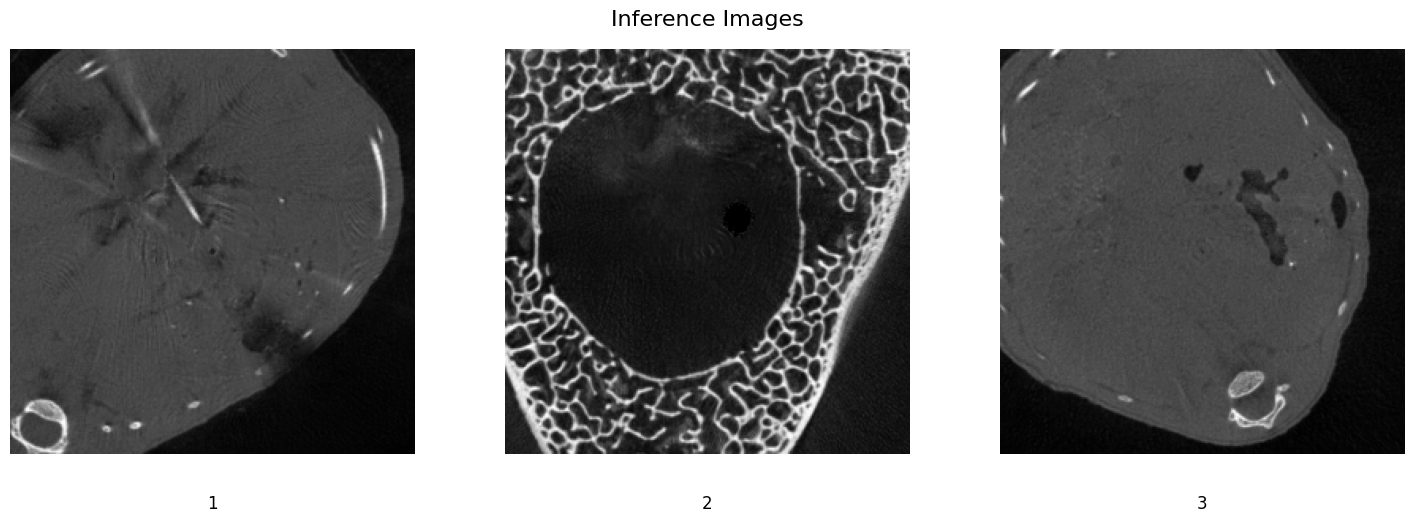

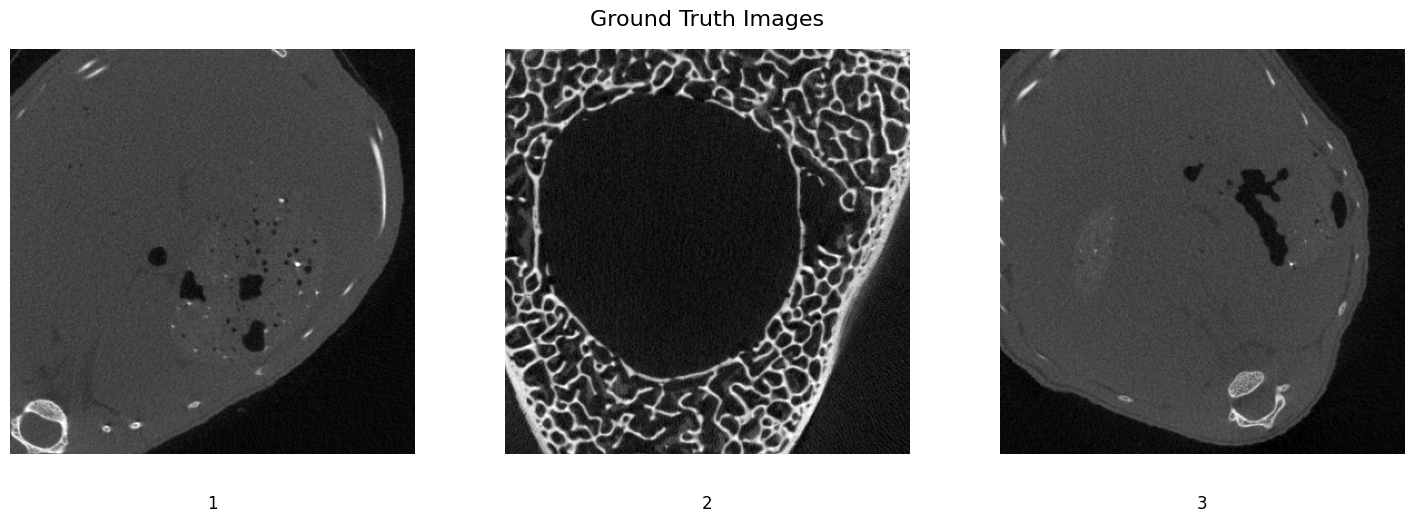

In [25]:
display_images(inference_images, "Inference Images")
display_images(gt_images, "Ground Truth Images")

## Training Results

This section will visualize 1the training logs to show the training loss, SSIM and PNSR over the epochs.

You will need the expriment json file path in `exp_path`

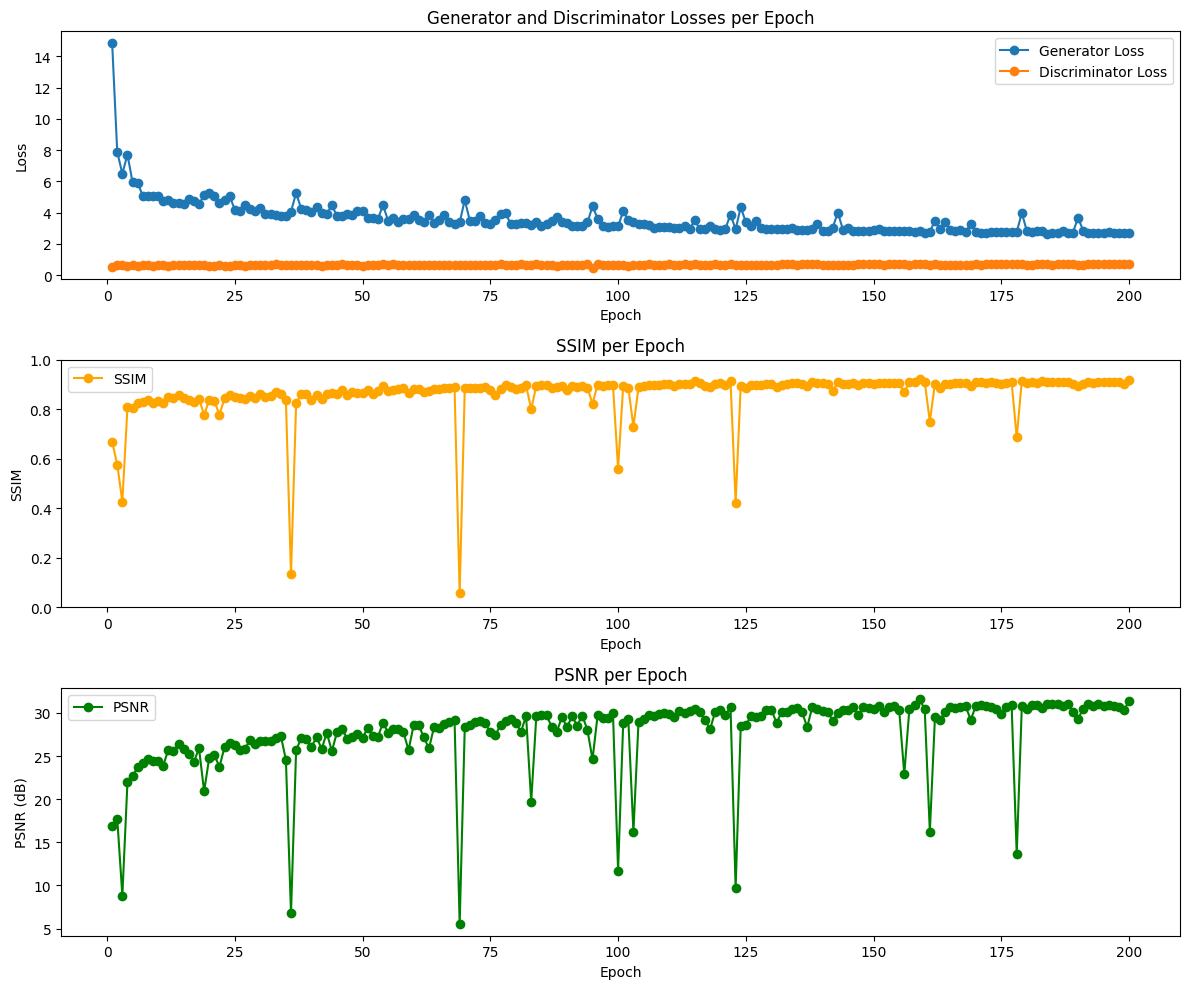

In [26]:
# Read the exp logs file
with open(exp_path, "r") as file:
    data = json.load(file)

# Extract data into lists for plotting
epochs = list(map(int, data["generator_loss"].keys()))
generator_loss = list(data["generator_loss"].values())
discriminator_loss = list(data["discriminator_loss"].values())
ssim = list(data["SSIM"].values())
psnr = list(data["PSNR"].values())

# Plot Generator and Discriminator Losses
plt.figure(figsize=(12, 10))

# Plot 1: Generator and Discriminator Losses
plt.subplot(3, 1, 1)
plt.plot(epochs, generator_loss, label="Generator Loss", marker='o')
plt.plot(epochs, discriminator_loss, label="Discriminator Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Losses per Epoch")
plt.legend()

# Plot 2: SSIM
plt.subplot(3, 1, 2)
plt.plot(epochs, ssim, label="SSIM", color="orange", marker='o')
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.title("SSIM per Epoch")
plt.ylim(0, 1)  # SSIM is typically between 0 and 1
plt.legend()

# Plot 3: PSNR
plt.subplot(3, 1, 3)
plt.plot(epochs, psnr, label="PSNR", color="green", marker='o')
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.title("PSNR per Epoch")
plt.legend()

plt.tight_layout()
plt.show()

## Evaluation

This section computes the average SSIM and PSNR of the model on the Test set

### Methods 

In [39]:
# Process and evaluate PNG images
def process_and_evaluate_image(ma_image_path, gt_image_path):
    # Load artifact-affected image
    ma_image = Image.open(ma_image_path).convert("L")  # Assuming grayscale images
    ma_tensor = transform(ma_image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Generate the cleaned image
    with torch.no_grad():
        generated_tensor = generator(ma_tensor)

    # Remove batch dimension and apply inverse transform
    generated_image = inverse_transform(generated_tensor.squeeze(0).cpu())

    # Load and process the ground truth image
    gt_image = Image.open(gt_image_path).convert("L")
    gt_tensor = transform(gt_image).unsqueeze(0).to(device)
    gt_image = inverse_transform(gt_tensor.squeeze(0).cpu())

    # Convert images to NumPy arrays for PSNR and SSIM calculation
    generated_np = np.array(generated_image)
    gt_np = np.array(gt_image)

    # Calculate PSNR and SSIM
    psnr_value = psnr(gt_np, generated_np, data_range=generated_np.max() - generated_np.min())
    ssim_value = ssim(gt_np, generated_np, data_range=generated_np.max() - generated_np.min())
    
    return psnr_value, ssim_value

# Calculate average PSNR and SSIM for the test directory
def calculate_average_metrics(test_dir):
    metal_dir = os.path.join(test_dir, 'Metal')
    gt_dir = os.path.join(test_dir, 'GT')
    
    psnr_total = 0.0
    ssim_total = 0.0
    num_images = 0
    
    # Iterate over images in the Metal directory
    for filename in tqdm(os.listdir(metal_dir), desc="Processing Images", unit="image"):
        ma_image_path = os.path.join(metal_dir, filename)
        gt_image_path = os.path.join(gt_dir, filename)  # Assume GT image has the same name

        # Check if the corresponding GT image exists
        if os.path.exists(gt_image_path):
            psnr_value, ssim_value = process_and_evaluate_image(ma_image_path, gt_image_path)
            psnr_total += psnr_value
            ssim_total += ssim_value
            num_images += 1
        else:
            print(f"Warning: GT image for {filename} not found in {gt_dir}")

    # Calculate average metrics
    avg_psnr = psnr_total / num_images if num_images > 0 else 0
    avg_ssim = ssim_total / num_images if num_images > 0 else 0

    print(f"Average PSNR: {avg_psnr:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")

### Running Testing 

In [40]:
# Calculate and print average PSNR and SSIM
calculate_average_metrics(Dataset_path)

Processing Images: 100%|██████████| 2352/2352 [00:41<00:00, 57.16image/s]

Average PSNR: 29.0140
Average SSIM: 0.8514
